Good afternoon, and welcome to this data model.
Today we are going to observe how we used draft eligible college basketball data to determine the success a player would have in the NBA.

We have a lot of raw data, our college-stats file contains a deluge of all college players that played between the years 2009-2021, whether they made the NBA or not, and our common_player files and draft_combine files contain data across the entire history of the NBA.

Below, we will start by defining success in the nba. We will have 3 classifications. A player is a star if they made an all star team, which we have compiled manually, a player is solid if they played at least 5 years in the nba (i.e. they were good enough to get a second contract after their rookie contract), and a player is a bust if they played less than 5 years in the NBA.

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import star_players
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
import ipywidgets as widgets
from IPython.display import display, clear_output
warnings.filterwarnings("ignore")


def classify_player(row):
    if row['display_first_last'] in (star_players.get_star_players()):
        return 'STAR'
    elif row['to_year'] - row['from_year'] >= 5:
        return 'SOLID'
    else:
        return 'BUST'


Next, we wil perform some preprocessing of the raw data files in order to create a clean dataset that we can use to train our model. We wont go over everything we do in the cleaning process, but essentially, we will apply the classification function above to the data, as well select data that is most significant for analysis. We will display a sample of the data below that should show a good mix of stars, solid players and busts.

In [72]:

college_df = pd.read_csv("college-stats.csv", low_memory=False)

college_df = college_df.loc[college_df.groupby('player_name')['year'].idxmax()]

nba_df = pd.read_csv("common_player_info.csv")
draft_year = 2009

nba_df = nba_df[nba_df["from_year"] >= draft_year]

nba_df.sort_values(by=['from_year'], inplace=True)

nba_df['classification'] = nba_df.apply(classify_player, axis=1)

# We will remove the college players that most recently entered the NBA, as we do not have enough information to determine
# whether they are a bust or a solid player yet.
nba_df = nba_df[
        ~(
            (nba_df['from_year'] >= 2019) &
            (nba_df['to_year'] >= 2023) &
            (nba_df['classification'] == 'BUST')
        )
    ]



columns = ['display_first_last', 'classification', 'from_year', 'to_year', 'school']

nba_df = nba_df[columns]


nba_df.to_csv('output.csv', index=False)




classified__nba_df = pd.read_csv("output.csv")

# Merge college statistics with NBA player names
clean_data = classified__nba_df.merge(college_df, left_on=['display_first_last', 'from_year'], right_on=['player_name', 'year'], how='inner')

# Merge draft combine dataa with NBA player names.
draft_combine = pd.read_csv("draft_combine_stats.csv")
clean_data = clean_data.merge(draft_combine, left_on='display_first_last', right_on='player_name', how='inner')

# transform the year players are into their numerical equivalent
clean_data['yr'] = clean_data['yr'].replace({'Fr': 1, 'So': 2, 'Jr': 3, 'Sr': 4})

# Only select relevant data for model
clean_data = clean_data[star_players.get_training_columns()]
clean_data.to_csv('output.csv', index=False)
clean_data.sample(10)



,display_first_last,classification,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,...,ast,stl,blk,pts,height_wo_shoes,height_w_shoes,weight,wingspan,standing_reach,body_fat_pct
127,Jae Crowder,SOLID,35,82.4,122.3,22.0,56.8,59.85,7.0,20.5,...,2.0857,2.5143,1.0000,17.5429,76.75,78.50,241.2,81.25,99.5,9.00
18,Blake Griffin,STAR,35,80.6,117.6,31.1,65.7,64.77,14.2,32.2,...,2.2857,1.1143,1.1714,22.6857,80.50,82.00,248.4,83.25,105.0,8.20
183,Jabari Brown,BUST,35,91.5,119.3,24.7,55.9,62.17,1.7,11.5,...,1.9143,0.6286,0.1429,19.9429,75.00,76.25,201.9,80.25,100.0,6.05
189,Zach LaVine,STAR,37,60.7,107.3,19.0,52.4,54.48,2.4,9.5,...,1.7838,0.8919,0.1622,9.4324,76.50,77.75,180.9,80.25,100.0,4.70
104,Michael Kidd-Gilchrist,SOLID,40,77.8,111.8,21.3,51.1,57.05,10.3,16.1,...,1.8750,0.9750,0.9250,11.9000,77.75,79.50,232.8,84.00,104.5,7.00
242,Ike Anigbogu,BUST,29,26.2,106.1,18.7,56.4,56.41,13.3,19.9,...,0.2069,0.1724,1.2069,4.7241,80.50,81.75,252.2,90.25,110.5,5.40
305,Jordan Bone,BUST,36,81.5,116.6,21.9,52.3,55.78,2.0,8.2,...,5.8108,0.7027,0.1081,13.4595,73.50,74.75,179.0,75.25,95.0,5.00
119,Austin Rivers,SOLID,34,82.4,104.8,24.0,50.5,53.84,2.2,9.2,...,2.0882,0.9706,0.0294,15.5000,75.50,77.00,202.8,79.25,96.5,6.20
38,Derrick Caracter,BUST,27,53.9,103.5,27.3,57.5,59.84,12.0,21.7,...,1.1111,0.9630,0.8519,14.0741,80.25,81.50,280.0,84.25,107.5,12.80
90,Klay Thompson,STAR,34,83.0,107.6,31.9,52.5,57.37,2.6,14.0,...,3.7353,1.6471,0.9412,21.5588,77.75,79.25,205.6,81.00,103.5,8.00


Awesome! we can see that for every player listed, we have their associated statistics and measurements. One final bit of preprocessing will be to remove player names, as our random forest model can only accept numerical input

In [73]:

clean_data = clean_data.drop('display_first_last', axis=1)



Next, we will now look at a visualization that shows the distribution of the three different classifications of NBA players, "stars",
"solid" players, and "busts

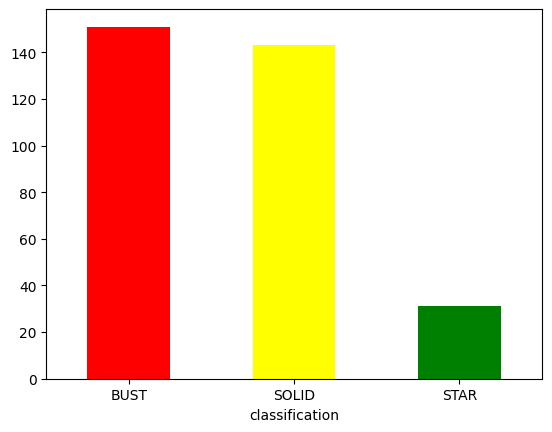

In [74]:
classifications = clean_data.groupby(by='classification').size()
plot = classifications.plot.bar(color=['red', 'yellow','green'],rot=0)


As we can see above, we have relatively even numbers of busts and solid players, with very few star players.

We will now begin the process of training the model, specifically a random forest model.

First, lets split our data into test data and training data. We will need to identify the target result with is the classification of the player, and the independent variables, which are their college statistics and measurements

In [75]:
# identify independent and dependent variables
independentVars = clean_data.drop('classification', axis=1)
dependentVar = clean_data['classification']

training_independent, test_independent, training_dependent, test_dependent = train_test_split(independentVars, dependentVar, test_size=0.1, random_state=24, stratify=dependentVar)

Above we have defined our traiing and test data, as well as isolated the variable (classification) that we want to train our model on.
Actually training the model to a baseline level is quite simple. We will train a random forest model below as well as test it using our designated data.

The accuracy of the model is: 64%


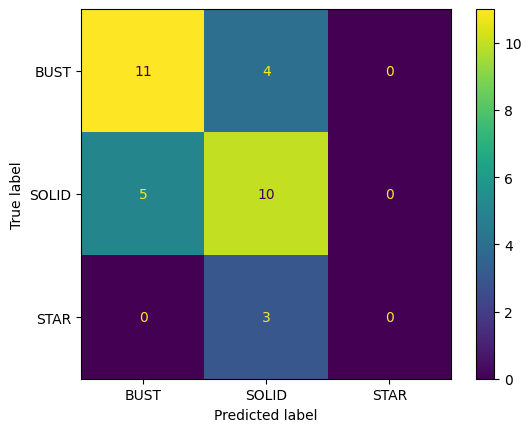

In [76]:



# create default tree
random_forest = RandomForestClassifier(random_state= 26)

random_forest.fit(training_independent, training_dependent)

predictions = random_forest.predict(test_independent)



accuracy = accuracy_score(test_dependent, predictions)
print("The accuracy of the model is: " + str(round(accuracy * 100)) + '%')



ConfusionMatrixDisplay.from_estimator(random_forest, test_independent, test_dependent)



Above, we can see that our model is accurate roughly ~64% of the time, but when we look at the confusion matrix generated, we find that our model does a relatively decent job predicting whether a player would be either solid or a bust, but does quite poorly with predicting star players. Lets see if we can improve the accuracy of model by fine-tuning it below

The accuracy of the model is: 70%


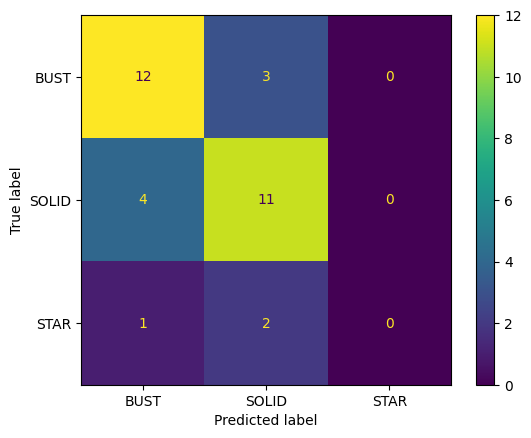

In [77]:


params = {'n_estimators': randint(1,1000),
          'max_depth': randint(1,50)}


random_forest_2 = RandomForestClassifier(random_state= 26)


#use a hyperparameter tuning algorithm to attempt to find the best random forest with the best hyperparameters
search_engine = RandomizedSearchCV(random_forest_2, param_distributions=params, n_iter=5, cv=5, random_state=26)

search_engine.fit(training_independent, training_dependent)

best_random_forest = search_engine.best_estimator_

newPredictions = best_random_forest.predict(test_independent)

accuracy2 = accuracy_score(test_dependent, newPredictions)

# print(best_random_forest.predict(independentVars))
# print(independentVars['porpag'])


print("The accuracy of the model is: " + str(round(accuracy2 * 100)) + '%')

ConfusionMatrixDisplay.from_estimator(best_random_forest, test_independent, test_dependent)

Above, we can see that while we used RandomizedSearchCV to randomly select the hyperparameters needed to create the best random forest, we were able to improve the accuracy by roughly 6%. However, we did not see any improvement in the models ability to accurately predict star players. In the future, further enhancements that can be added to the project to enable it to predict stars more accurately would be to increase the sample size of star players.

For now, lets take a look at the features the model deemed most important and predictive during its training




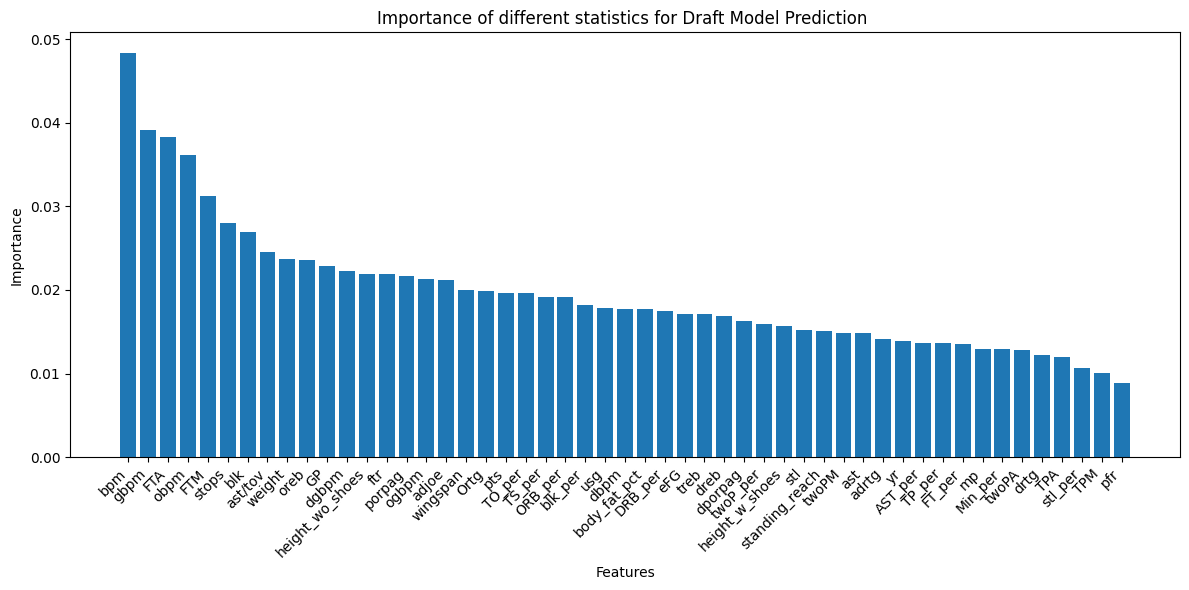

In [78]:
features = independentVars.columns
importance = best_random_forest.feature_importances_

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Importance of different statistics for Draft Model Prediction ')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Looking at the chart above, we can see some interesting results. The statistics that are seen as most determinative of a players success in the nba include free throws, both the players ability to shoot them, as well as their abiiity to draw free throws in the first place, box plus minus, or how well a team performs when a player is on the court vs off the court, and the year of school they are in. This follows conventional wisdom, in that free throws are widely seaen as the strongest indicator of a players ability to shoot, and scouts most often prefer to draft younger players over older players, as the former has more room to grow than the latter.

Another thing we can potentially do to improve the model would be to prune some of the less important statistics from the model, in order to let the more important statistics guide the models training.

# USER INTERFACE FOR TESTING INPUT BELOW

The code below is available for users who want to test the capabilities of the model for themselves. Player data has many different input points,  so for simplicity and ease of use, I provided the data for three NBA players that were drafted recently that are not in the dataset.

To test the data below, you can either
* Use prepopulated data from any of the three players provided to quickly test the model
* Fill in the 51 input fields with user data


In [79]:



sample_data = pd.DataFrame([
    {
        # Dalton Knecht SOLID
        "GP": 35, "Min_per": 80.2, "Ortg": 130.8,
        "usg": 20.2, "eFG": 66, "TS_per": 68.99, "ORB_per": 11, "DRB_per": 21.9, "AST_per": 6.7, "TO_per": 12.3,
        "FTM": 113, "FTA": 145, "FT_per": 0.779, "twoPM": 198, "twoPA": 299, "twoP_per": 0.662, "TPM": 0, "TPA": 1,
        "TP_per": 0, "blk_per": 3.3, "stl_per": 1, "ftr": 48.3, "yr": 1, "porpag": 5.88808, "adjoe": 137.154,
        "pfr": 3.3, "ast/tov": 0.72090181, "drtg": 95.9973, "adrtg": 89.8587, "dporpag": 4.05345, "stops": 210.51,
        "bpm": 7.45978, "obpm": 4.83715, "dbpm": 2.62263, "gbpm": 7.47108, "mp": 32.5429, "ogbpm": 5.79765,
        "dgbpm": 1.67343, "oreb": 2.4857, "dreb": 5.7143, "treb": 8.2, "ast": 0.8857, "stl": 0.4857, "blk": 0.8571,
        "pts": 14.5429, "height_wo_shoes": 80.75, "height_w_shoes": 82, "weight": 239.6, "wingspan": 85,
        "standing_reach": 107, "body_fat_pct": 5.5
    },
    {
        # Jalen Hood-Schifino,BUST
        "GP": 33, "Min_per": 28.5, "Ortg": 94.7,
        "usg": 23.4, "eFG": 45.8, "TS_per": 48.2, "ORB_per": 2.1, "DRB_per": 10.0, "AST_per": 16.5, "TO_per": 15.8,
        "FTM": 50, "FTA": 75, "FT_per": 66.7, "twoPM": 100, "twoPA": 240, "twoP_per": 41.7, "TPM": 20, "TPA": 80,
        "TP_per": 25.0, "blk_per": 0.3, "stl_per": 1.0, "ftr": 0.20, "yr": "1", "porpag": 1.5, "adjoe": 98.0,
        "pfr": 0.14, "ast/tov": 0.8, "drtg": 110.0, "adrtg": 112.0, "dporpag": 1.2, "stops": 0.8, "bpm": -0.5,
        "obpm": -0.8, "dbpm": 0.3, "gbpm": -0.2, "mp": 900, "ogbpm": -0.6, "dgbpm": 0.2, "oreb": 15, "dreb": 100,
        "treb": 115, "ast": 110, "stl": 20, "blk": 5, "pts": 350, "height_wo_shoes": 77.0, "height_w_shoes": 78.0,
        "weight": 200, "wingspan": 80.0, "standing_reach": 98.0, "body_fat_pct": 7.0
    },
    {
        # Austin Reaves STAR
        "GP": 35, "Min_per": 88.3, "Ortg": 112.8,
        "usg": 32.6, "eFG": 55.3, "TS_per": 60.66, "ORB_per": 5.5, "DRB_per": 14.6, "AST_per": 29.2, "TO_per": 19,
        "FTM": 204, "FTA": 270, "FT_per": 0.756, "twoPM": 163, "twoPA": 289, "twoP_per": 0.564, "TPM": 58, "TPA": 163,
        "TP_per": 0.356, "blk_per": 1.1, "stl_per": 3.1, "ftr": 59.7, "yr": 2, "porpag": 6.47615, "adjoe": 137.102,
        "pfr": 3.2, "ast/tov": 1.25425636, "drtg": 95.6385, "adrtg": 89.5229, "dporpag": 4.50387, "stops": 234.839,
        "bpm": 10.3738, "obpm": 7.16968, "dbpm": 3.20412, "gbpm": 9.8125, "mp": 35.8286, "ogbpm": 6.88906,
        "dgbpm": 2.92344, "oreb": 1.3714, "dreb": 4.2, "treb": 5.5714, "ast": 4.2286, "stl": 1.6857, "blk": 0.3143,
        "pts": 20.1143, "height_wo_shoes": 76, "height_w_shoes": 77.25, "weight": 222, "wingspan": 82.75,
        "standing_reach": 103.5, "body_fat_pct": 10.1
    }
])

all_columns = sample_data.columns

widgets_dict = {
    col: widgets.FloatText(description=col) for col in all_columns
}

output_box = widgets.Output()

def prepopulate_data(row):
    for col in all_columns:
        widgets_dict[col].value = row[col]

def collect_data():
    new_row = {col: wid.value for col, wid in widgets_dict.items()}
    new_df = pd.DataFrame([new_row])
    return best_random_forest.predict(new_df)
    # return new_df

def submit_data(data):
    output_box.clear_output()
    with output_box:
        print(f"Result: {data}")

def on_submit_click(b):
    submit_data(collect_data())

buttons = []
for i, row in sample_data.iterrows():
    button = widgets.Button(description=f"Prepopulate Player {i+1}")
    button.on_click(lambda b, r=row: prepopulate_data(r))
    buttons.append(button)


submit_button = widgets.Button(description="Submit")
submit_button.on_click(on_submit_click)



In [80]:
# Display
for widget in widgets_dict.values():
    display(widget)
for button in buttons:
    display(button)
display(submit_button, output_box)


FloatText(value=0.0, description='GP')

FloatText(value=0.0, description='Min_per')

FloatText(value=0.0, description='Ortg')

FloatText(value=0.0, description='usg')

FloatText(value=0.0, description='eFG')

FloatText(value=0.0, description='TS_per')

FloatText(value=0.0, description='ORB_per')

FloatText(value=0.0, description='DRB_per')

FloatText(value=0.0, description='AST_per')

FloatText(value=0.0, description='TO_per')

FloatText(value=0.0, description='FTM')

FloatText(value=0.0, description='FTA')

FloatText(value=0.0, description='FT_per')

FloatText(value=0.0, description='twoPM')

FloatText(value=0.0, description='twoPA')

FloatText(value=0.0, description='twoP_per')

FloatText(value=0.0, description='TPM')

FloatText(value=0.0, description='TPA')

FloatText(value=0.0, description='TP_per')

FloatText(value=0.0, description='blk_per')

FloatText(value=0.0, description='stl_per')

FloatText(value=0.0, description='ftr')

FloatText(value=0.0, description='yr')

FloatText(value=0.0, description='porpag')

FloatText(value=0.0, description='adjoe')

FloatText(value=0.0, description='pfr')

FloatText(value=0.0, description='ast/tov')

FloatText(value=0.0, description='drtg')

FloatText(value=0.0, description='adrtg')

FloatText(value=0.0, description='dporpag')

FloatText(value=0.0, description='stops')

FloatText(value=0.0, description='bpm')

FloatText(value=0.0, description='obpm')

FloatText(value=0.0, description='dbpm')

FloatText(value=0.0, description='gbpm')

FloatText(value=0.0, description='mp')

FloatText(value=0.0, description='ogbpm')

FloatText(value=0.0, description='dgbpm')

FloatText(value=0.0, description='oreb')

FloatText(value=0.0, description='dreb')

FloatText(value=0.0, description='treb')

FloatText(value=0.0, description='ast')

FloatText(value=0.0, description='stl')

FloatText(value=0.0, description='blk')

FloatText(value=0.0, description='pts')

FloatText(value=0.0, description='height_wo_shoes')

FloatText(value=0.0, description='height_w_shoes')

FloatText(value=0.0, description='weight')

FloatText(value=0.0, description='wingspan')

FloatText(value=0.0, description='standing_reach')

FloatText(value=0.0, description='body_fat_pct')

Button(description='Prepopulate Player 1', style=ButtonStyle())

Button(description='Prepopulate Player 2', style=ButtonStyle())

Button(description='Prepopulate Player 3', style=ButtonStyle())

Button(description='Submit', style=ButtonStyle())

Output()